In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -U pyarrow > /dev/null

In [4]:
!pip install "dask[dataframe]" --upgrade  > /dev/null

#Tensorrec will be used as our model for recommendation.
https://towardsdatascience.com/getting-started-with-recommender-systems-and-tensorrec-8f50a9943eef

In [7]:
pip install tensorrec  > /dev/null

In [8]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import preprocessing
from collections import Counter
import scipy.sparse as sparse
import os
from tqdm import tqdm
import keras as ks
import tensorrec
from tensorrec import TensorRec
from tensorrec.eval import *
from tensorrec.util import append_to_string_at_point


### the rest of these representation graphs are also available as an alternative

from tensorrec.representation_graphs import (AbstractKerasRepresentationGraph, 
#                                              ReLURepresentationGraph, 
                                             NormalizedLinearRepresentationGraph, 
#                                              LinearRepresentationGraph
                                            )

from tensorrec.loss_graphs import WMRBLossGraph 
from tensorrec.eval import fit_and_eval, eval_random_ranks_on_dataset
from tensorrec.util import append_to_string_at_point

### we need to construct a Keras representation graph by inheriting tensorrec.representation_graphs.AbstractKerasRepresentationGraph
### https://www.tensorflow.org/tensorboard/graphs
### many thanks to James Kirk for his article: 
### https://medium.com/hackernoon/deep-learning-for-recommendation-with-keras-and-tensorrec-2b8935c795d0

class DeepRepresentationGraph(AbstractKerasRepresentationGraph):

    # This method returns an ordered list of Keras layers connecting the user/item features to the user/item
    # representation. When TensorRec learns, the learning will happen in these layers.
    def create_layers(self, n_features, n_components):
        return [
            ks.layers.Dense(n_components * 16, activation='relu'), 
            ks.layers.Dense(n_components * 8, activation='relu'),
            ks.layers.Dense(n_components * 2, activation='relu'),
            ks.layers.Dense(n_components, activation='tanh'),
        ]

In [9]:
### Jesse Steinweg-Woods provide a great elaboration on Recommendation metrics
### The following code is borrowed from his work
### https://jessesw.com/Rec-System/

def interaction_masking(interactions):
    '''
    This function will "mask" (a.k.a "hide") 20% of original interactions
    Masked items wil be considered not purchased

    '''
    mask_size = len(interactions.data)
    mask = np.random.choice(a=[False, True], size=mask_size, p=[.2, .8])
    not_mask = np.invert(mask)

    train_interactions = sparse.coo_matrix((interactions.data[mask],
                                        (interactions.row[mask],
                                         interactions.col[mask])),
                                       shape=interactions.shape)

    test_interactions = sparse.coo_matrix((interactions.data[not_mask],
                                       (interactions.row[not_mask],
                                        interactions.col[not_mask])),
                                      shape=interactions.shape)

    return train_interactions, test_interactions

# You need to download sparse data from the previous step
https://drive.google.com/drive/u/1/folders/1CaJiTPw5B-qLjh_46G84sujRQ_TtqNQS

In [10]:
interaction_f = sparse.load_npz('./drive/My Drive/npz_data/interaction_f.npz')
user_f = sparse.load_npz('./drive/My Drive/npz_data/user_f.npz')
item_f = sparse.load_npz('./drive/My Drive/npz_data/item_f.npz')

In [11]:
# Create a masked train and test dataset of the interaction features
train_interactions, test_interactions = interaction_masking(interaction_f)

# Feed the user and item features
user_features  = user_f
item_features = item_f

# Also, you can download our weights of the mode:
https://drive.google.com/drive/folders/1-2SGZczIwS83Q_sV01fjZyp-sSVqNOhh?usp=sharing

In [ ]:
%%time
## model parameters

epochs = 5000
alpha = 0.01 
n_components =  10

verbose = True
learning_rate = 0.01
n_sampled_items = int(item_features.shape[0] * .1)
biased = False

model = TensorRec(n_components = n_components,                 
                  user_repr_graph = DeepRepresentationGraph(),
                   item_repr_graph = NormalizedLinearRepresentationGraph(),
                   loss_graph = WMRBLossGraph(), 
                  biased=biased)

model.fit(train_interactions, 
          user_features, 
          item_features, 
          epochs=epochs, 
          verbose=False, 
          alpha=alpha, 
          n_sampled_items=n_sampled_items,
          learning_rate=learning_rate)


# # Get predicted scores for all users and all items
# predictions = model.predict(user_features=user_features,
#                             item_features=item_features)

# Get the predicted rankings (First, second, third, and so forth...) for all users and all items
predicted_ranks = model.predict_rank(user_features=user_features,
                                     item_features=item_features)

In [ ]:
### TESTING

# we use Recall@k
# Recall@k: for the average user, what percentage of their test items made it in to the top k in the predicted rankings

# in other words, recall@k:
# what percentage of the positively interacted items (items purchased) were in the top k results of the prediction?

# in simpler words:
# Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)
#a.k.a
# Recall@k = (# of recommended items @k ) / (total # items purchased)

## optimally, if you have around 400-500 products, you want to achieve recall at k ≈ 200-250
r_at_k_test = recall_at_k(predicted_ranks, test_interactions, k=5000)
r_at_k_train = recall_at_k(predicted_ranks, train_interactions, k=5000)
print("Recall at @k: Train: {:.2f} Test: {:.2f}".format(r_at_k_train.mean(), r_at_k_test.mean()))

In [ ]:
model.save_model("My_chkpt.pth")

In [69]:
ranks_df = pd.DataFrame(predicted_ranks)
ranks_df.columns = item_category_scaled.index
ranks_df.index = customer_features.index
ranks_df = ranks_df.T

In [70]:
ranks_df.head()

client_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
material,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3154,2926,3101,3519,9481,5179,10538,1686,6681,5292,2026,4799,3147,3112,5810,4557,6612,2929,2807,5131,3119,10540,3841,4645,4542,5633,4110,5238,10533,5154,7336,9530,3353,1587,5445,1582,6607,3901,4825,3537,...,6566,4486,6597,4423,4377,3205,4065,10523,4680,4212,3101,3505,3282,3046,2999,4335,2923,5110,5952,6646,2992,6346,6559,3917,4767,3167,9484,9483,5504,10472,3092,6697,4474,3059,8906,3128,3473,2807,6057,3548
13,8300,7346,8539,9473,8586,9466,9172,7745,8427,8407,9137,8802,8396,8259,7877,9675,8558,8735,7316,8898,8391,9565,9485,9612,9126,9662,8718,8962,9254,9669,8654,8661,6923,7932,8284,7663,8407,9380,8956,8292,...,8367,8531,8861,9642,7800,8179,9360,9362,9251,8902,8369,8230,7421,8233,8381,9530,8557,9134,9861,8524,9109,9000,9715,9573,9413,8496,8543,8872,9131,9272,8514,8518,9654,8475,8439,8461,8046,8510,9177,8260
16,1253,9446,1242,6628,6906,10113,3272,10273,10340,10676,3767,10154,5989,1236,10717,7935,10344,1394,9434,10138,6125,2941,6452,8942,10500,5764,9886,2202,3148,8480,9898,6872,9376,10204,10740,10203,10350,5586,9824,10752,...,10456,10664,10536,5008,10438,6459,6412,2820,9704,9961,1234,10750,9043,1266,5854,6265,6181,10240,4923,10319,6866,10601,8198,5174,9903,6143,6829,6835,10199,3117,1240,10348,6451,1253,9823,1282,10756,5498,10275,10749
21,3489,4979,3476,4558,6995,4432,3817,10116,7092,5749,3970,3825,7035,3476,6255,4199,7101,3542,5052,3975,6882,3931,4397,4288,5205,4114,3520,4184,3849,4032,3682,6869,5007,10148,6398,10148,7150,4502,3557,10488,...,7142,6002,6846,4312,5686,6781,4391,4002,4027,3666,3473,10501,5339,3481,6653,4268,6373,4328,4211,7152,5627,6593,3946,4357,4165,6976,7020,7018,4405,3881,3478,7033,4296,3470,3596,3487,10427,6313,4536,10527
24,3644,6599,3619,3688,3809,4100,3455,6938,2902,6648,2442,4060,4178,3618,7170,3873,2882,3453,6745,3971,4176,3480,3692,4099,5244,3547,4365,5053,3461,3799,3346,3803,5196,6606,7142,6570,2897,3594,3938,9021,...,3153,6336,3311,3643,6321,4350,3690,3524,4105,4381,3616,9043,5174,3599,4040,3643,4150,4127,3624,2841,4125,3732,3460,3529,4173,4210,3845,3840,3903,3482,3615,2924,3669,3610,3172,3614,8980,3829,3759,9021


# Visualization of metrics

In [13]:
epochs = 500
fit_kwargs = {'epochs': 1, 'alpha': 0.01, 'verbose': True, 'learning_rate': .01,
              'n_sampled_items': int(item_features.shape[0] * .1)}

test_model = TensorRec(n_components = 10,                 
                  user_repr_graph = DeepRepresentationGraph(),
                   item_repr_graph = NormalizedLinearRepresentationGraph(),
                   loss_graph = WMRBLossGraph(), 
                  biased=False)

In [14]:
def f1_measure(rec, pres):
  return 2 * rec * pres / (rec + pres)

def train_and_test():
  prec = []
  rec = []
  f1 = []
  for epoch in tqdm(range(epochs)):
      test_model.fit_partial(interactions=train_interactions,
                        user_features=user_features,
                        item_features=item_features,
                        **fit_kwargs)
      predicted_ranks = test_model.predict_rank(user_features=user_features,
                                      item_features=item_features)
      
      p_at_k_test = precision_at_k(predicted_ranks, test_interactions, k=7000)
      r_at_k_test = recall_at_k(predicted_ranks, test_interactions, k=7000)
      prec.append(p_at_k_test.mean() * 100)
      rec.append(r_at_k_test.mean())
      # f1.append(f1_measure(r_at_k_test.mean(), p_at_k_test.mean()))
  return prec, rec, f1

In [15]:
prec, rec, f1 = train_and_test()

  0%|          | 0/500 [00:00<?, ?it/s]/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
100%|██████████| 500/500 [08:47<00:00,  1.06s/it]


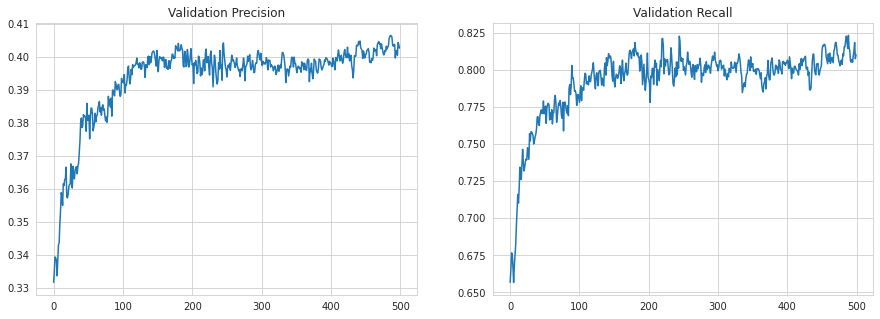

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Validation Precision')
ax2.set_title('Validation Recall')
x = np.arange(epochs)
ax1.plot(x, prec)
ax2.plot(x, rec)